In [1]:
import pandas as pd
import xgboost as xgb
import numpy as np
import optuna
from optuna.samplers import TPESampler, RandomSampler
import pickle
import os
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from scipy.stats import pearsonr, linregress
from sklearn.ensemble import RandomForestRegressor, RandomForestRegressor

from sklearn.preprocessing import MinMaxScaler

sel_target = "MSH3"

activity_cols = ['Oligo_ID', 'Gene Species', 'Scaled', 'Train-Test-Split', 'Screen']

AttributeError: module 'matplotlib.pyplot' has no attribute 'savef'

In [113]:
feature_columns = [ line.strip() for line in open("FeatSet3_columns.txt").readlines()]
dataset = pd.read_parquet('disirna.all_features_v2.features_v2.parquet.gzip')
dataset["Oligo_ID"] = dataset["Oligo_ID"].str.replace("PRNP-Human|PRNP-Mouse","PRNP",regex=True)
dataset["Gene"] = dataset["Gene"].str.replace("PRNP-Human|PRNP-Mouse","PRNP",regex=True)
print(sum(dataset.columns.isin(["Gene"])))



scaled_data = pd.read_csv("All_data_2023-09-22_scaled.csv")
scaled_data["Scaled"] = scaled_data["scaled"]
merge_dataset = dataset.merge(scaled_data,on=["Oligo_ID","Gene"],how="inner",copy=True)

merge_dataset.shape

1


(3528, 290)

In [114]:


msh3_data = pd.DataFrame(merge_dataset.loc[merge_dataset["gene_species"]=="MSH3_Human"])
train = pd.DataFrame(msh3_data.sample(frac = 0.5,random_state=1))

# test = pd.read_csv("../dataset/tiling_reg_dataset.csv")
# optimize = pd.read_csv("../dataset/primary_reg_dataset.csv")
# train = pd.DataFrame(optimize[train.columns.to_list()])

# # train = pd.concat([train,optimize],join="inner")
non_train = pd.DataFrame(msh3_data[~msh3_data["Oligo_ID"].isin(train["Oligo_ID"])])
optimize = pd.DataFrame(non_train.sample(frac = 0.5,random_state=1))
test = pd.DataFrame(non_train[~non_train["Oligo_ID"].isin(optimize["Oligo_ID"])])

In [115]:
print("Num of Train",train.shape[0])
print("Num of Optimize",optimize.shape[0])
print("Num of Test",test.shape[0])
print("Num of Test in Train",sum(test["Oligo_ID"].isin(train["Oligo_ID"])))
print("Num of Test in Optimize",sum(optimize["Oligo_ID"].isin(test["Oligo_ID"])))
print("Num of Optimize in Train",sum(optimize["Oligo_ID"].isin(train["Oligo_ID"])))

Num of Train 202
Num of Optimize 100
Num of Test 101
Num of Test in Train 0
Num of Test in Optimize 0
Num of Optimize in Train 0


In [116]:
train["Scaled"] = train["Scaled"]

In [117]:
train['Oligo_ID'].str.split('_').str[0].unique()

array(['MSH3'], dtype=object)

In [118]:
print(optimize.shape)
print(train.shape)
print(test.shape)
print(test.shape[0]+optimize.shape[0])

(100, 290)
(202, 290)
(101, 290)
201


In [119]:
train[train['Gene']=='MSH3']

# sum(train["Oligo_ID"].isin(optimize["Oligo_ID"]) )


,Transcript_Pos,Oligo_ID,Sequence,revcomp_seq,antisense_oligo,gc,sense_oligo,sirna_seed,mirna_seed,score_region,...,IC50 notes,Protein % UNT,Flag?,Selected for IC50?,Selected for In vivo?,In vivo % KD (max),In vivo description,scaled,Random Numbers,Scaled
679,3400,MSH3_NM_002439.4_3400,UUGCAAAGUUAUGGACGAUGC,GCAUCGUCCAUAACUUUGCAA,UCAUCGUCCAUAACUUUGCAA,38.095238,AAGUUAUGGACGAUGA,AAAGTTATGGACGATG,CAUCGUC,GAGACUCAAGUAUUUUGCAAAGUUAUGGACGAUGCAUAAUGCACA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.033960,261,1.033960
282,608,MSH3_NM_002439.4_608,CGCAAAGAAUGCAGUUUCUUC,GAAGAAACUGCAUUCUUUGCG,UAAGAAACUGCAUUCUUUGCG,38.095238,AGAAUGCAGUUUCUUA,AAGAATGCAGTTTCTT,AAGAAAC,AUCAGUCUUCUACACGCAAAGAAUGCAGUUUCUUCUGAAGAUUCG,...,NaN,NaN,NaN,Yes,NaN,NaN,NaN,0.107481,314,0.107481
693,3587,MSH3_NM_002439.4_3587,UGUGAGCAUAAAAUUAUGACC,GGUCAUAAUUUUAUGCUCACA,UGUCAUAAUUUUAUGCUCACA,28.571429,GCAUAAAAUUAUGACA,AGCATAAAATTATGAC,GUCAUAA,AUCUUUGUGUGACAUGUGAGCAUAAAAUUAUGACCAUGGUAUAUU,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.498902,110,0.498902
312,804,MSH3_NM_002439.4_804,CAGCACAAAGAUGCAGUUUUG,CAAAACUGCAUCUUUGUGCUG,UAAAACUGCAUCUUUGUGCUG,38.095238,CAAAGAUGCAGUUUUA,ACAAAGATGCAGTTTT,AAAACUG,UAGAAAUGAAGCAGCAGCACAAAGAUGCAGUUUUGUGUGUGGAAU,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.374005,254,0.374005
465,1471,MSH3_NM_002439.4_1471,AAUACAGCCAUGCUUUCCAGG,CCUGGAAAGCAUGGCUGUAUU,UCUGGAAAGCAUGGCUGUAUU,42.857143,AGCCAUGCUUUCCAGA,CAGCCATGCTTTCCAG,CUGGAAA,UAACAUUUAUUUUGAAUACAGCCAUGCUUUCCAGGCAGUUACAGA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.856354,315,0.856354
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
667,3260,MSH3_NM_002439.4_3260,UAGAGGAAUUGCAGCAAGGAG,CUCCUUGCUGCAAUUCCUCUA,UUCCUUGCUGCAAUUCCUCUA,42.857143,GAAUUGCAGCAAGGAA,GGAATTGCAGCAAGGA,UCCUUGC,CUUUACCAAAUAACUAGAGGAAUUGCAGCAAGGAGUUAUGGAUUA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.683269,79,0.683269
488,1550,MSH3_NM_002439.4_1550,UGGCAUUGUUAACUUAGAGAA,UUCUCUAAGUUAACAAUGCCA,UUCUCUAAGUUAACAAUGCCA,33.333333,UUGUUAACUUAGAGAA,ATTGTTAACTTAGAGA,UCUCUAA,UCUCAAAUUAUUUCUGGCAUUGUUAACUUAGAGAAGCCUGUGAUU,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.160713,87,0.160713
299,731,MSH3_NM_002439.4_731,UUCCAAAUCAGCUAACAAACG,CGUUUGUUAGCUGAUUUGGAA,UGUUUGUUAGCUGAUUUGGAA,33.333333,AAUCAGCUAACAAACA,AAATCAGCTAACAAAC,GUUUGUU,UUACAGAAAACUGCUUCCAAAUCAGCUAACAAACGGUCCAAAAGC,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.459021,223,0.459021
701,3670,MSH3_NM_002439.4_3670,CUUCCUAACUUUUCUACGUAU,AUACGUAGAAAAGUUAGGAAG,UUACGUAGAAAAGUUAGGAAG,33.333333,UAACUUUUCUACGUAA,CTAACTTTTCTACGTA,UACGUAG,UUUCAAGUUUCUGUCUUCCUAACUUUUCUACGUAUAAACACUCUU,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.514799,54,0.514799


In [120]:
df=pd.DataFrame()
df['ID_match'] = test['Oligo_ID'].isin(train['Oligo_ID']).any()
df

,ID_match


In [121]:
def trend_plot(y_preds, y_test,title,outfile):

        # m, b = np.polyfit(y_preds, y_test, 1)
        linear_fit = linregress(y_preds,y_test)
        slope = linear_fit.slope
        pvalue = linear_fit.pvalue
        intercept = linear_fit.intercept

        pcc_res = pearsonr(y_preds,y_test)
        plt.figure(figsize=(10,6))
        ax = plt.scatter(x=y_preds,y=y_test)
        if max(y_preds) > 1.8:
            plt.xlim(-0.1,1.1)
            text_x = -190
        else:
            plt.xlim(min(y_preds)*0.9,max(y_preds)*1.1)
            text_x = min(y_preds)
            text_y = max(y_test)
        textstr = "\n".join(['Regression Line: y = {:.6f}x + {:.2f}'.format(slope, intercept),"P-value: " + str(pvalue),"corr: "+str(pcc_res.statistic)])
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

        # fig = plt.figure()
        
        plt.ylim(-0.1,1.4)
        plt.plot(y_preds, intercept + slope*y_preds ,color="black")

        # place a text box in upper left in axes coords
        plt.text(text_x, text_y, textstr, fontsize=10, verticalalignment='top', bbox=props)
        plt.title(title)
        plt.xlabel('Predictions')
        plt.ylabel('Actual')
        plt.savefig(outfile)
        plt.close()

# trend_plot(optimize_preds, y_opt, title=study.study_name+' '+str(n_trials)+" trials_training", outfile="../outputs/RandomForestRegressor/plots_scn9a_splits/"+"pt_scatter_optimize_"+study.study_name+"_trials_"+str(n_trials))

In [122]:
test

,Transcript_Pos,Oligo_ID,Sequence,revcomp_seq,antisense_oligo,gc,sense_oligo,sirna_seed,mirna_seed,score_region,...,IC50 notes,Protein % UNT,Flag?,Selected for IC50?,Selected for In vivo?,In vivo % KD (max),In vivo description,scaled,Random Numbers,Scaled
15,987,MSH3_NM_002439.4_987,AAGGUGGGAGUUGUGAAGCAA,UUGCUUCACAACUCCCACCUU,UUGCUUCACAACUCCCACCUU,47.619048,GGGAGUUGUGAAGCAA,TGGGAGTTGTGAAGCA,UGCUUCA,UGGCAAAAGGAUAUAAGGUGGGAGUUGUGAAGCAAACUGAAACUG,...,NaN,NaN,NaN,Yes,Yes,73.27,ATLAS081 HP 28d protein 5nmol,0.253703,366,0.253703
19,988,MSH3_NM_002439.4_988,AGGUGGGAGUUGUGAAGCAAA,UUUGCUUCACAACUCCCACCU,UUUGCUUCACAACUCCCACCU,47.619048,GGAGUUGUGAAGCAAA,GGGAGTTGTGAAGCAA,UUGCUUC,GGCAAAAGGAUAUAAGGUGGGAGUUGUGAAGCAAACUGAAACUGC,...,NaN,NaN,NaN,Yes,NaN,NaN,NaN,0.278724,333,0.278724
20,990,MSH3_NM_002439.4_990,GUGGGAGUUGUGAAGCAAACU,AGUUUGCUUCACAACUCCCAC,UGUUUGCUUCACAACUCCCAC,47.619048,AGUUGUGAAGCAAACA,GAGTTGTGAAGCAAAC,GUUUGCU,CAAAAGGAUAUAAGGUGGGAGUUGUGAAGCAAACUGAAACUGCAG,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.434099,84,0.434099
72,993,MSH3_NM_002439.4_993,GGAGUUGUGAAGCAAACUGAA,UUCAGUUUGCUUCACAACUCC,UUCAGUUUGCUUCACAACUCC,42.857143,UGUGAAGCAAACUGAA,TTGTGAAGCAAACTGA,UCAGUUU,AAGGAUAUAAGGUGGGAGUUGUGAAGCAAACUGAAACUGCAGCAU,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.378569,245,0.378569
234,997,MSH3_NM_002439.4_997,UUGUGAAGCAAACUGAAACUG,CAGUUUCAGUUUGCUUCACAA,UAGUUUCAGUUUGCUUCACAA,33.333333,AAGCAAACUGAAACUA,GAAGCAAACTGAAACT,AGUUUCA,AUAUAAGGUGGGAGUUGUGAAGCAAACUGAAACUGCAGCAUUAAA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.412095,339,0.412095
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
692,3579,MSH3_NM_002439.4_3579,GUGUGACAUGUGAGCAUAAAA,UUUUAUGCUCACAUGUCACAC,UUUUAUGCUCACAUGUCACAC,38.095238,ACAUGUGAGCAUAAAA,GACATGTGAGCATAAA,UUUAUGC,AACAGCCUAUCUUUGUGUGACAUGUGAGCAUAAAAUUAUGACCAU,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.591668,399,0.591668
695,3601,MSH3_NM_002439.4_3601,UAUGACCAUGGUAUAUUCCUA,UAGGAAUAUACCAUGGUCAUA,UAGGAAUAUACCAUGGUCAUA,33.333333,CCAUGGUAUAUUCCUA,ACCATGGTATATTCCT,AGGAAUA,UGUGAGCAUAAAAUUAUGACCAUGGUAUAUUCCUAUUGGAAACAG,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.534548,249,0.534548
702,3680,MSH3_NM_002439.4_3680,UUUCUACGUAUAAACACUCUU,AAGAGUGUUUAUACGUAGAAA,UAGAGUGUUUAUACGUAGAAA,28.571429,ACGUAUAAACACUCUA,TACGTATAAACACTCT,AGAGUGU,CUGUCUUCCUAACUUUUCUACGUAUAAACACUCUUGAAUAGACUU,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.573536,286,0.573536
708,3702,MSH3_NM_002439.4_3702,AAUAGACUUCCACUUUGUAAU,AUUACAAAGUGGAAGUCUAUU,UUUACAAAGUGGAAGUCUAUU,28.571429,ACUUCCACUUUGUAAA,GACTTCCACTTTGTAA,UUACAAA,UAUAAACACUCUUGAAUAGACUUCCACUUUGUAAUUAGAAAAUUU,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.501981,376,0.501981


In [123]:
X_train = train[feature_columns]
y_train = train['Scaled']
print(sum(X_train.columns.isin(activity_cols)))
X_opt = optimize[feature_columns]
y_opt = optimize['Scaled']
X_test = test[feature_columns]
y_test = test['Scaled']
print(X_train.shape)
print(X_opt.shape)
print(X_test.shape)
n_trials=5
# Create the Optuna study
# study = create_study(direction='minimize', study_name=gene_species)
model_path = "../outputs/model"
model_filename = f'pt_xgbr_trail_{n_trials}_featset1_orig.pkl'



0
(202, 218)
(100, 218)
(101, 218)


(array([0.09122139, 0.72977112, 1.36832084, 2.09809196, 1.55076362,
        0.9122139 , 1.00343529, 0.82099251, 0.18244278, 0.45610695]),
 array([0.02659285, 0.13513089, 0.24366892, 0.35220695, 0.46074498,
        0.56928301, 0.67782105, 0.78635908, 0.89489711, 1.00343514,
        1.11197317]),
 <BarContainer object of 10 artists>)

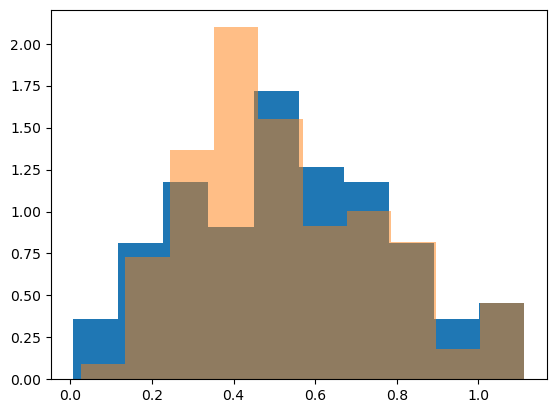

In [124]:
plt.hist(y_opt,density=True)
plt.hist(y_test,density=True,alpha=0.5)

In [130]:
n_trials=50

# Define the objective function
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int('n_estimators', 2, 100),
        "max_depth": trial.suggest_int('max_depth', 2, 10),
        # "min_samples_split": trial.suggest_int('min_samples_split', 30, 100),
        # "min_samples_leaf": trial.suggest_int('min_samples_leaf', 30, 100),
        # "max_features": trial.suggest_categorical('max_features', ['log2', 'sqrt',None]),
        "max_features": trial.suggest_float("max_features",0,0.5),
        # "max_leaf_nodes": trial.suggest_int('max_leaf_nodes', 30, 100),
        # "bootstrap": trial.suggest_categorical('bootstrap', [True, False]),
        "max_samples": trial.suggest_float("max_samples",0.5,1)
    }

    model = RandomForestRegressor(**params,n_jobs=16, random_state=7,bootstrap=True)
    # model = xgb.XGBRegressor(n_estimators=n_estimators, max_depth=max_depth, reg_alpha=reg_alpha, gamma=gamma,
    #     reg_lambda=reg_lambda, colsample_bytree=colsample_bytree, min_child_weight=min_child_weight, 
    #     learning_rate=learning_rate, objective='reg:squarederror',subsample=subsample, n_jobs=64, seed=51)


    model.fit(X_train, y_train)

    y_pred = model.predict(X_opt)
    # scaler  = MinMaxScaler()
    # y_pred = scaler.fit_transform(pred.reshape(-1, 1))

    mse = mean_squared_error(y_opt, y_pred)
    mae = mean_absolute_error(y_opt, y_pred)
    # r2_score_val = r2_score(y_opt, y_pred)
    # y_pred = model.predict(X_test)
    # mse = mean_squared_error(y_test, y_pred)
    # print(mse)

    # res = pearsonr(y_test, y_pred) #Unable to use statistic with xgb
    # statistic = res.statistic
    return mae

# n_trials=500
sampler = TPESampler(seed=5)
# sampler = RandomSampler(seed=5)
study = optuna.create_study(direction='minimize', study_name="MSH3_pt", sampler=sampler)
study.optimize(objective, n_trials=n_trials, n_jobs=1)

# optuna.logging.set_verbosity(optuna.logging.WARNING)



best_params = study.best_params
print(best_params)
model = RandomForestRegressor(**best_params,random_state=51,n_jobs=16,)
model.fit(X_train, y_train)
with open(os.path.join(model_path, model_filename), 'wb') as f:
    pickle.dump(model, f)
scaler  = MinMaxScaler()
predictions = model.predict(X_test)
training_preds = model.predict(X_train)
optimize_preds = model.predict(X_opt)

# plt.hist(predictions)
# plt.hist(training_preds)
# plt.hist(optimize_preds)


mse = mean_squared_error(y_test, predictions)
res = pearsonr(y_test, predictions)
statistic = res.statistic
pvalue = res.pvalue

training_mse = mean_squared_error(y_train, training_preds)
training_res = pearsonr(y_train, training_preds)
training_statistic = training_res.statistic
training_pvalue = training_res.pvalue

optimize_res = pearsonr(y_opt, optimize_preds)

test_df = test.copy()
test_df['Predictions'] = predictions
test_df['Model'] = "XGBoostRegressor"
test_df['Correlation'] = statistic
test_df['n_trials'] = n_trials
test_df['Feature_set'] = "Featset1"
test_df['Param_space'] = "Original"
test_set_out = test_df[['Oligo_ID', 'Scaled', 'Predictions', 'Correlation', 'Model', 'n_trials', 'Feature_set', 'Param_space']]

scores_dataframe = pd.DataFrame(
{"Model": "RandomForestRegressor",
"Feature_set": "Featset1",
"Param_space": "Original",
"Gene": "SCN9A_pt",
"train_statistic":[training_statistic],
"test_statistic":[statistic],
"train_P_value": [training_pvalue],
"test_P_value": [pvalue],
"test_Mean_Squared_Error":[mse], 
"train_Mean_Squared_Error":[training_mse], 
"n_trials":n_trials, 
"Total_train":len(y_train),
"Total_test":len(y_test)} | best_params)

# Append the best hyperparameters to the scores dataframe
# scores_dataframe.append(best_params, ignore_index=True)
# optuna.visualization.matplotlib.plot_optimization_history(study)
# plt.title("Optimization history - " + study.study_name+' '+str(n_trials)+" trials")
# plt.savefig("plots/"+study.study_name+"_trials_"+str(n_trials))
# plt.close()
# print(predictions)
# print(y_test.mean())
# print(y_test.shape)
plt.tight_layout()
trend_plot(predictions, y_test, title=study.study_name+' '+str(n_trials)+" trials_test", outfile="../outputs/RandomForestRegressor/"+"pt_scatter_test_"+study.study_name+"_trials_"+str(n_trials))
trend_plot(training_preds, y_train, title=study.study_name+' '+str(n_trials)+" trials_training", outfile="../outputs/RandomForestRegressor/"+"pt_scatter_training_"+study.study_name+"_trials_"+str(n_trials))
trend_plot(optimize_preds, y_opt, title=study.study_name+' '+str(n_trials)+" trials_optimizing", outfile="../outputs/RandomForestRegressor/"+"pt_scatter_optimize_"+study.study_name+"_trials_"+str(n_trials))

# return scores_dataframe, test_set_out

# Iterate over the unique gene species and train and evaluate the model for each gene species

# scores_dataframe.to_csv('XG_scores_mse.csv', index=False)
# scores = pd.read_csv('XG_scores_mse.csv')
scores_dataframe.to_csv(f'../outputs/RandomForestRegressor/pt_scn9a_split_results_{n_trials}.csv', index=None)
test_set_out.to_csv(f"../outputs/RandomForestRegressor/pt_scn9a_split_preds_{n_trials}.csv", index=None)
# metrics.to_csv("Num_trials_"+str(n_trials)+'_XGBR_scores_MSE.csv', index=False)

[I 2023-12-29 16:02:46,457] A new study created in memory with name: MSH3_pt
[I 2023-12-29 16:02:46,529] Trial 0 finished with value: 0.18546893064300654 and parameters: {'n_estimators': 23, 'max_depth': 9, 'max_features': 0.10335957766971321, 'max_samples': 0.9593054539689607}. Best is trial 0 with value: 0.18546893064300654.
[I 2023-12-29 16:02:46,635] Trial 1 finished with value: 0.1802547283201638 and parameters: {'n_estimators': 50, 'max_depth': 7, 'max_features': 0.3829539282401578, 'max_samples': 0.7592089939364717}. Best is trial 1 with value: 0.1802547283201638.


[I 2023-12-29 16:02:46,721] Trial 2 finished with value: 0.19276116666109622 and parameters: {'n_estimators': 31, 'max_depth': 3, 'max_features': 0.04037063438243743, 'max_samples': 0.869220148099485}. Best is trial 1 with value: 0.1802547283201638.
[I 2023-12-29 16:02:46,825] Trial 3 finished with value: 0.18647346097402115 and parameters: {'n_estimators': 45, 'max_depth': 3, 'max_features': 0.43996851560063943, 'max_samples': 0.6370432309961123}. Best is trial 1 with value: 0.1802547283201638.
[I 2023-12-29 16:02:46,918] Trial 4 finished with value: 0.17771638123111214 and parameters: {'n_estimators': 43, 'max_depth': 4, 'max_features': 0.31439395443974166, 'max_samples': 0.7899189050947726}. Best is trial 4 with value: 0.17771638123111214.
[I 2023-12-29 16:02:47,039] Trial 5 finished with value: 0.18648586052654523 and parameters: {'n_estimators': 61, 'max_depth': 4, 'max_features': 0.1423429403206819, 'max_samples': 0.6267941028868937}. Best is trial 4 with value: 0.177716381231112

{'n_estimators': 87, 'max_depth': 6, 'max_features': 0.2430011900005635, 'max_samples': 0.8598385937494851}


<Figure size 640x480 with 0 Axes>

(array([ 3.,  6., 18., 12., 13., 22., 12.,  6.,  4.,  5.]),
 array([0.33910137, 0.38555297, 0.43200458, 0.47845618, 0.52490779,
        0.57135939, 0.617811  , 0.6642626 , 0.71071421, 0.75716581,
        0.80361742]),
 <BarContainer object of 10 artists>)

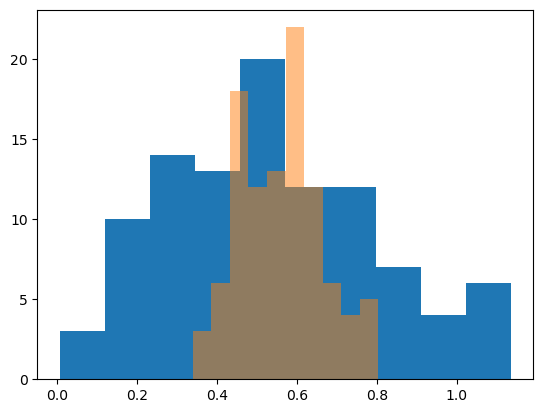

In [64]:
# trend_plot(optimize_preds, y_opt, title=study.study_name+' '+str(n_trials)+" trials_training", outfile="../outputs/RandomForestRegressor/plots_scn9a_splits/"+"pt_scatter_optimize_"+study.study_name+"_trials_"+str(n_trials))
# plt.hist(training_preds)
plt.hist(y_test)
plt.hist(predictions,alpha=0.5)

In [65]:
scores_dataframe.transpose()

,0
Model,RandomForestRegressor
Feature_set,Featset1
Param_space,Original
Gene,SCN9A_pt
train_statistic,0.971543
test_statistic,0.443616
train_P_value,0.0
test_P_value,0.000003
test_Mean_Squared_Error,0.05566
train_Mean_Squared_Error,0.008687


/tmp/ipykernel_244345/3921955970.py:1: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study)


Text(0.5, 1.0, 'Optimization history - MSH3_pt 50 trials')

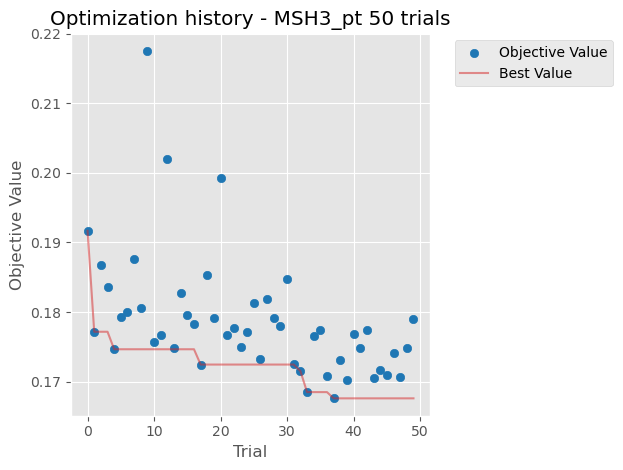

In [66]:
optuna.visualization.matplotlib.plot_optimization_history(study)
plt.tight_layout()
plt.title("Optimization history - " + study.study_name+' '+str(n_trials)+" trials")
# plt.close()